# Classification supervisée d'images

Maintenant je fais la même chose sauf que je supervise mes images et je fais une "data augmentation" (j'augmente le nombre d'images de mon dataframe en modifiant mes images, ex: zoom, rotation, ...)

In [1]:
import pandas as pd
import nltk
import json  
import sys  
import numpy as np

import seaborn as sns  
import matplotlib.pyplot as plt  
from sklearn.manifold import TSNE  
from sklearn.decomposition import PCA  
import random  

from nltk.stem.snowball import EnglishStemmer
import plotly.express as px  
from sklearn.preprocessing import LabelEncoder  
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier  
from sklearn.metrics import adjusted_rand_score
from sklearn.metrics import classification_report, accuracy_score  
from sklearn.metrics import confusion_matrix  
from sklearn.cluster import KMeans

import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator  
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Flatten, Dense, Dropout 
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.vgg16 import preprocess_input as preprocess_input_vgg16
from tensorflow.keras.applications.vgg19 import preprocess_input as preprocess_input_vgg19
from tensorflow.keras.preprocessing.image import load_img  as load_img, img_to_array  as img_to_array
from tensorflow.keras.utils import to_categorical


In [2]:
def modify_labels(y_true, y_pred):  
    """  
    Modifies the predicted values based on the confusion matrix.  
    """  
    cm = confusion_matrix(y_true, y_pred)  
    n_classes = len(np.unique(y_true))  
    modified_pred = np.copy(y_pred)
    
    mapping = {}
    for true_label in range(n_classes): 
        max_count = -1  
        for pred_label in range(n_classes):
            if cm[true_label, pred_label] > max_count and pred_label not in mapping.values():  
                max_count = cm[true_label, pred_label]
                mapping[true_label] = pred_label
        
        # print(mapping)
        # # print(mapping)
        # print(f"Replace y_pred {mapping[true_label]} by {true_label}, because {max_count}")
        # print()
    for true_label, pred_label in mapping.items():  
         modified_pred[y_pred == pred_label] = true_label
        
    return modified_pred
  
def get_cnn_model():
    # Get pre trained model
    model0 = VGG16(include_top=False, weights="imagenet", input_shape=(224, 224, 3))

    # Only new layers will be trained
    for layer in model0.layers:
        layer.trainable = False

    # Get the output
    x = model0.output
    
    # Complete the model
    x = GlobalAveragePooling2D()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    predictions = Dense(4, activation='softmax')(x)

    # Define the new model
    model = Model(inputs=model0.input, outputs=predictions)
    
    # Compile the model
    model.compile(loss="categorical_crossentropy", optimizer='rmsprop', metrics=["accuracy"])

    print(model.summary())
    
    return model

def images_to_array(data):
    prepared_images = []
    for image_num in range(len(data['img_path'])) :
        img = (load_img(
            data['img_path'][image_num],
            target_size=(224, 224)))
        img = img_to_array(img)
        img = img.reshape((img.shape[0], img.shape[1], img.shape[2]))
        img = preprocess_input_vgg16(img)
        prepared_images.append(img)
        prepared_images_np = np.array(prepared_images)
    return prepared_images_np

In [3]:
df = pd.read_csv("./../input/df_cleaned_v2.csv")

# df_x_train, df_x_test, df_y_train, df_y_test = train_test_split(df, df["cat_e"], test_size=0.3, random_state=42)


### Recap non supervisé

J'affiche de nouveau le score de mon modele de base non supervisé.

In [4]:
base_model = VGG16()
model = Model(inputs=base_model.inputs, outputs=base_model.layers[-2].output)

In [5]:
images_features = []
i=0 
for image_file in df["img_path"] :
    if i%100 == 0 : print(i)
    i +=1
    image = load_img(image_file, target_size=(224, 224))
    image = img_to_array(image) 
    image = np.expand_dims(image, axis=0)
    image = preprocess_input_vgg16(image)
    images_features.append(model.predict(image, verbose=0)[0]) # predict from pretrained model

images_features = np.asarray(images_features)
images_features.shape

0
100
200
300
400
500
600


/Users/m/.pyenv/versions/3.10.12/lib/python3.10/site-packages/PIL/Image.py:3157: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


700
800
900
1000


(1050, 4096)

In [6]:
pca = PCA(n_components=0.99, random_state=42)
feat_pca= pca.fit_transform(images_features)

tsne = TSNE(n_components=2, perplexity=120, random_state=42)
X_tsne = tsne.fit_transform(feat_pca)

df_tsne = pd.DataFrame(X_tsne, columns=['tsne1', 'tsne2'])
df_tsne["class"] = df["cat"]

cls = KMeans(n_clusters=7, n_init=100, random_state=42)
cls.fit(X_tsne)
df_tsne["cluster"] = cls.labels_
clusters_adjusted = modify_labels(df['cat_e'], df_tsne["cluster"]) 

print("Score minimum")
print("ARI : {:.2f}".format(adjusted_rand_score(df["cat"], clusters_adjusted)))  
print("Accuracy : {:.2f}".format(accuracy_score(df["cat_e"], clusters_adjusted)))  

Score minimum
ARI : 0.53
Accuracy : 0.74


## Approche supervisé

### Baseline

Je fais une baseline en supervisé

In [170]:
images_features = []  

for img_path in df["img_path"]:  
    img = load_img(img_path, target_size=(224, 224))  
    img = img_to_array(img)  
    img = img / 255.0  # Normalize the pixel values  
    images_features.append(img)

images_features = np.array(images_features)

/Users/m/.pyenv/versions/3.10.12/lib/python3.10/site-packages/PIL/Image.py:3157: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


In [174]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))  
print("Model loaded.")

# Do not retrain the layer so we don't change the weight of the new classifier
for layer in base_model.layers:  
    layer.trainable = False  

Model loaded.


J'ajoute un layer de 256 units avec une activation relu.  
Puis un dropout de 0.5 pour éviter l'overfitting

In [175]:
# Get the output of the last training result
x = base_model.output 
# Now if I want to use it to train the next layer, I need to use the last output, it has to be flatten
x = Flatten()(x)  
# I add one dense layer of 256 unit (relu for non linearity)
x = Dense(256, activation='relu')(x)
# Add dropout for regularization (overfitting)
x = Dropout(0.5)(x)
predictions = Dense(7, activation='softmax')(x)  # num_classes should match your dataset  
  
# Construct the final model  
model = Model(inputs=base_model.input, outputs=predictions)  


In [176]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])  

Je partage mon jeu de données pour tester 20% d'entre elles

In [177]:
X_train, X_test, y_train, y_test = train_test_split(images_features, df["cat_e"], test_size=0.2, random_state=42)  
y_train_one_hot = to_categorical(y_train)
y_test_one_hot = to_categorical(y_test)

In [179]:
# Train the model  
batch_size = 32
epochs = 50 

history = model.fit(  
    X_train, y_train_one_hot,  
    batch_size=batch_size,  
    epochs=epochs,  
    validation_data=(X_test, y_test_one_hot)  
)

Epoch 1/50
27/27 [==============================] - 94s 4s/step - loss: 2.9289 - accuracy: 0.4607 - val_loss: 0.9575 - val_accuracy: 0.6857
Epoch 2/50
27/27 [==============================] - 98s 4s/step - loss: 0.8713 - accuracy: 0.6869 - val_loss: 0.7030 - val_accuracy: 0.7714
Epoch 3/50
27/27 [==============================] - 99s 4s/step - loss: 0.6329 - accuracy: 0.7702 - val_loss: 0.6944 - val_accuracy: 0.7810
Epoch 4/50
27/27 [==============================] - 101s 4s/step - loss: 0.5023 - accuracy: 0.8190 - val_loss: 0.5792 - val_accuracy: 0.8048
Epoch 5/50
27/27 [==============================] - 101s 4s/step - loss: 0.4145 - accuracy: 0.8512 - val_loss: 0.5977 - val_accuracy: 0.8048
Epoch 6/50
27/27 [==============================] - 106s 4s/step - loss: 0.3285 - accuracy: 0.8774 - val_loss: 0.5423 - val_accuracy: 0.8190
Epoch 7/50
27/27 [==============================] - 108s 4s/step - loss: 0.2906 - accuracy: 0.9000 - val_loss: 0.5045 - val_accuracy: 0.8095
Epoch 8/50
27/27

In [181]:
predictions = model.predict(X_test)  
y_pred = np.argmax(predictions, axis=1)  
print(classification_report(y_test, y_pred))  
print("Test Accuracy: ", accuracy_score(y_test, y_pred))  

7/7 [==============================] - 19s 3s/step
              precision    recall  f1-score   support

           0       0.74      0.63      0.68        27
           1       0.82      0.67      0.74        21
           2       0.76      0.92      0.83        38
           3       0.86      0.83      0.85        30
           4       0.79      0.77      0.78        35
           5       0.79      0.88      0.84        26
           6       0.97      0.94      0.95        33

    accuracy                           0.82       210
   macro avg       0.82      0.81      0.81       210
weighted avg       0.82      0.82      0.82       210

Test Accuracy:  0.819047619047619


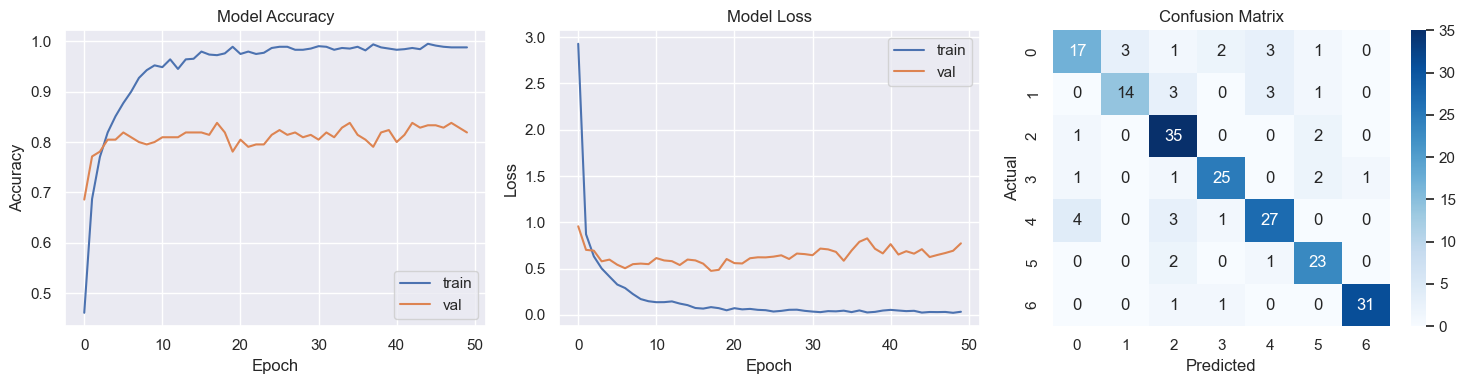

In [234]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4))  
  
# Plot Training and Validation Accuracy  
axes[0].plot(history.history['accuracy'])  
axes[0].plot(history.history['val_accuracy'])  
axes[0].set_title('Model Accuracy')  
axes[0].set_ylabel('Accuracy')  
axes[0].set_xlabel('Epoch')
axes[0].legend(['train', 'val'], loc='lower right')  
  
# Plot Training and Validation Loss  
axes[1].plot(history.history['loss'])  
axes[1].plot(history.history['val_loss'])  
axes[1].set_title('Model Loss')  
axes[1].set_ylabel('Loss')  
axes[1].set_xlabel('Epoch')  
axes[1].legend(['train', 'val'], loc='upper right')  
  
# Compute confusion matrix  
cm = confusion_matrix(y_test, y_pred)  
  
# Plot confusion matrix using heatmap  
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', ax=axes[2])  
axes[2].set_xlabel('Predicted')  
axes[2].set_ylabel('Actual')  
axes[2].set_title('Confusion Matrix')  
  
plt.tight_layout()  
plt.show()  

Bon score de précision. Maintenant avec une data augmentation

### Augmented

J'utilise la librairie Keras pour faire mon augmentation. Et j'observe les nouvelles images

In [193]:
train_datagen = ImageDataGenerator(  
    rotation_range=20,  
    width_shift_range=0.2,  
    height_shift_range=0.2,  
    shear_range=0.1,  
    zoom_range=0.2,  
    horizontal_flip=True,  
    fill_mode='nearest'  
)  
train_datagen.fit(X_train)

Exemple d'images "augmented"

[815, 692, 525]


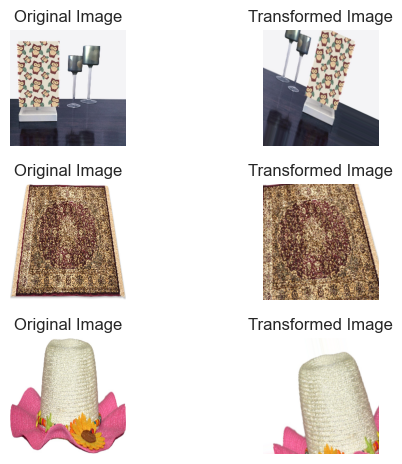

In [229]:
# Generate 3 random indices  
random_indices = [815, 692, 525]
# random_indices = random.sample(range(len(X_train)), 3)  

print(random_indices)

# Loop through the random indices  
for i, index in enumerate(random_indices):  
  
    # Plot the original image  
    plt.subplot(3, 2, i*2 + 1)  # Set up a grid of 3 rows and 2 columns  
    plt.imshow(X_train[index])
    plt.axis('off')
    plt.title(f'Original Image')
  
    # Plot the transformed image  
    plt.subplot(3, 2, i*2 + 2)  
    transformed_image = train_datagen.flow(X_train, batch_size=1, shuffle=False)[index][0]  
    plt.imshow(transformed_image)
    plt.axis('off')
    plt.title(f'Transformed Image')  
  
plt.tight_layout()  
plt.show()  

Même opération avant la data augmentation sur la création de layers

In [240]:
# Get the output of the last training result
x = base_model.output 
# Now if I want to use it to train the next layer, I need to use the last output, it has to be flatten
x = Flatten()(x)  
# I add one dense layer of 256 unit (relu for non linearity)
x = Dense(256, activation='relu')(x)
# Add dropout for regularization (overfitting)
x = Dropout(0.5)(x)
predictions = Dense(7, activation='softmax')(x)  # num_classes should match your dataset  
  
# Construct the final model  
model = Model(inputs=base_model.input, outputs=predictions)  

model_augmented = Model(inputs=base_model.input, outputs=predictions)  
model_augmented.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])  

In [235]:
history_augmented = model_augmented.fit(  
    train_datagen.flow(X_train, y_train_one_hot, batch_size=batch_size),  
    steps_per_epoch=len(X_train) // batch_size,  
    epochs=epochs,  
    validation_data=(X_test, y_test_one_hot)  
)

Epoch 1/50
26/26 [==============================] - 100s 4s/step - loss: 1.3034 - accuracy: 0.5359 - val_loss: 0.9971 - val_accuracy: 0.6619
Epoch 2/50
26/26 [==============================] - 101s 4s/step - loss: 1.1068 - accuracy: 0.6064 - val_loss: 0.8343 - val_accuracy: 0.7286
Epoch 3/50
26/26 [==============================] - 98s 4s/step - loss: 1.0801 - accuracy: 0.6275 - val_loss: 0.8521 - val_accuracy: 0.6952
Epoch 4/50
26/26 [==============================] - 104s 4s/step - loss: 0.9915 - accuracy: 0.6300 - val_loss: 0.7573 - val_accuracy: 0.7619
Epoch 5/50
26/26 [==============================] - 104s 4s/step - loss: 0.9784 - accuracy: 0.6733 - val_loss: 0.8146 - val_accuracy: 0.7048
Epoch 6/50
26/26 [==============================] - 113s 4s/step - loss: 0.8623 - accuracy: 0.6931 - val_loss: 0.7124 - val_accuracy: 0.7714
Epoch 7/50
26/26 [==============================] - 111s 4s/step - loss: 0.8410 - accuracy: 0.7005 - val_loss: 0.7332 - val_accuracy: 0.7286
Epoch 8/50
26/

In [236]:
predictions = model_augmented.predict(X_test)  
y_pred = np.argmax(predictions, axis=1)  
print(classification_report(y_test, y_pred))  
print("Test Accuracy: ", accuracy_score(y_test, y_pred))  

7/7 [==============================] - 20s 3s/step
              precision    recall  f1-score   support

           0       0.55      0.78      0.65        27
           1       0.80      0.76      0.78        21
           2       0.94      0.87      0.90        38
           3       0.82      0.77      0.79        30
           4       0.87      0.74      0.80        35
           5       0.88      0.88      0.88        26
           6       0.97      0.97      0.97        33

    accuracy                           0.83       210
   macro avg       0.83      0.82      0.83       210
weighted avg       0.85      0.83      0.83       210

Test Accuracy:  0.8285714285714286


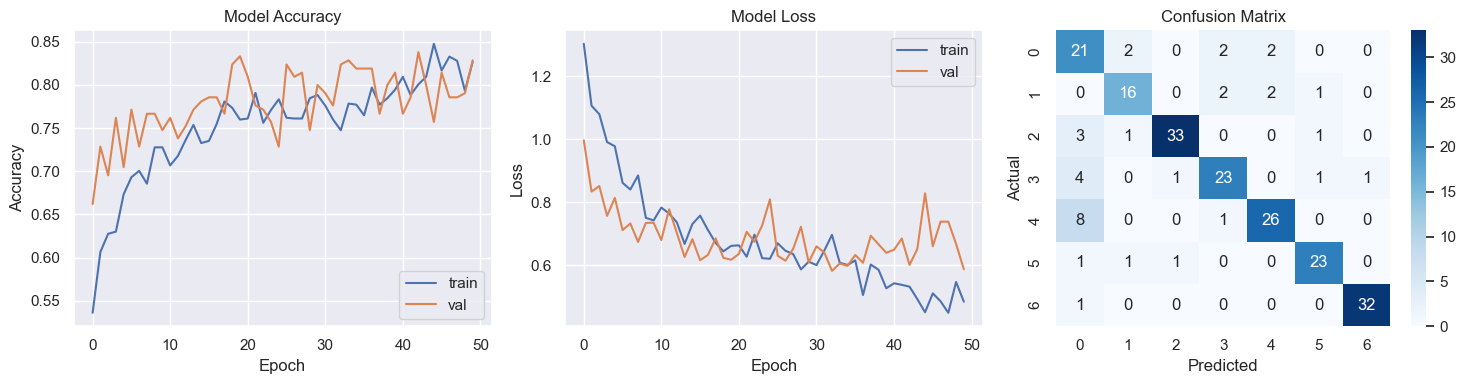

In [237]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4))  
  
# Plot Training and Validation Accuracy  
axes[0].plot(history_augmented.history['accuracy'])  
axes[0].plot(history_augmented.history['val_accuracy'])  
axes[0].set_title('Model Accuracy')  
axes[0].set_ylabel('Accuracy')  
axes[0].set_xlabel('Epoch')
axes[0].legend(['train', 'val'], loc='lower right')  
  
# Plot Training and Validation Loss  
axes[1].plot(history_augmented.history['loss'])  
axes[1].plot(history_augmented.history['val_loss'])  
axes[1].set_title('Model Loss')  
axes[1].set_ylabel('Loss')  
axes[1].set_xlabel('Epoch')  
axes[1].legend(['train', 'val'], loc='upper right')  
  
# Compute confusion matrix  
cm = confusion_matrix(y_test, y_pred)  
  
# Plot confusion matrix using heatmap  
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', ax=axes[2])  
axes[2].set_xlabel('Predicted')  
axes[2].set_ylabel('Actual')  
axes[2].set_title('Confusion Matrix')  
  
plt.tight_layout()  
plt.show()  

Légères amélioration.